In [238]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')

file_path = "../data/google_reviews/google reviews cleaned df_text.xlsx"
df = pd.read_excel(file_path)
print(df.columns)

Index(['rating', 'reservation_recommended', 'visited_on', 'wait_time',
       'published_date', 'is_local_guide', 'original_language', 'review_text'],
      dtype='object')


We begin pre-processing the google reviews with text for sentimental analysis.

In [239]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['review_text'] = df['review_text'].apply(clean_text)
df['is_english_speaker'] = df['original_language'].apply(lambda x: 1 if x == 'en' else 0)

df = df.drop(columns = ['reservation_recommended', 'wait_time', 'is_local_guide', 'original_language'])

Let's preview the dataset.

In [240]:
print(df.head())

   rating visited_on published_date  \
0       5    Weekday     2025-02-27   
1       5    Weekday     2025-02-27   
2       5    Weekday     2025-02-27   
3       5    Weekday     2025-02-27   
4       5    Weekday     2025-02-27   

                                         review_text  is_english_speaker  
0  great day universal studio singapore visited j...                   1  
1  universal studio singapore popular tourist des...                   0  
2                           amazing modern beautiful                   0  
3  one go theme park singapore also osaka japan u...                   1  
4  bit old still fun recommended play 16001900 pe...                   0  


Let's segment the reviews into 5 segments based on 'Stars'.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_17576\391236939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


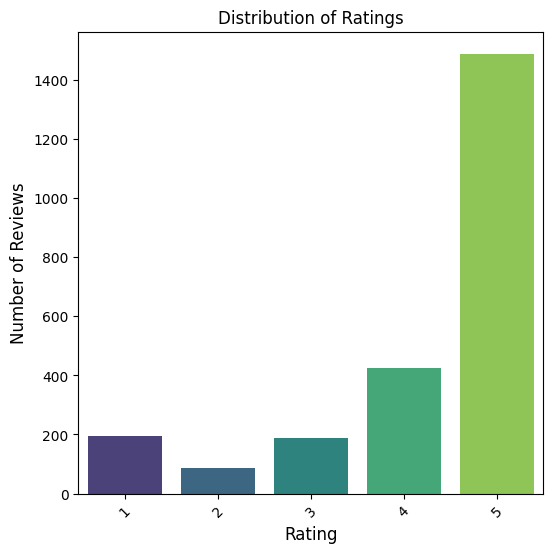

In [241]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(6, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=12)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()

Let's conduct sentimental analysis to better understand the tone behind the text data.

In [242]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['sentiment'] = df['review_text'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))
df['sentiment_label'].value_counts()

sentiment_label
positive    1887
neutral      275
negative     218
Name: count, dtype: int64

We follow up by plotting the sentiment label against the stars of the review.

C:\Users\HopeE\AppData\Local\Temp\ipykernel_17576\3653652341.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')


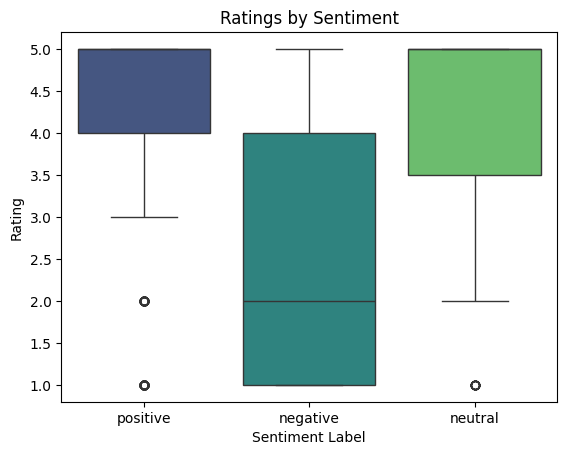

In [243]:
sns.boxplot(x='sentiment_label', y='rating', data=df, palette='viridis')
plt.title('Ratings by Sentiment')
plt.xlabel('Sentiment Label')
plt.ylabel('Rating')
plt.show()

We now look for the probable occurances of high-risk interactions stated in the reviews. We define "high-risk interaction" as revirews with ratings 1-2 stars and reviews with highly negative sentiment scores. We proceed to create a list of high-risk keywords and identify the frequency of occurance of these keywords in the filtered out "high-risk" reviews.

In [244]:
# Define high-risk keywords

from sklearn.preprocessing import MinMaxScaler


high_risk_keywords = ['accident', 'injury', 'unsafe', 'dangerous', 'broken', 'malfunction',
                        'sick', 'poisoning', 'crowded', 'long wait', 'unhygienic', 'fell', 'hurt',
                        'defective', 'improper', 'hazard', 'inadequate', 'negligence', 'danger',
                        'bad', 'terrible', 'disappointing', 'angry', 'anger', 'terrified', 'afriad']

def engineer_features(df, keywords):
    featured_df = df.copy()

    # Create interaction feature between rating and sentiment
    featured_df['rating_sentiment_diff'] = featured_df['rating']/5 - (featured_df['sentiment'] + 1)/2
    
    # Create feature for review length (might indicate detail of complaint)
    featured_df['review_length'] = featured_df['review_text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    for keyword in keywords:
        featured_df[f'has_{keyword}'] = featured_df['review_text'].apply(
            lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
        )
    
    # Create a complaint keyword count feature
    featured_df['complaint_keyword_count'] = featured_df[[f'has_{keyword}' for keyword in keywords]].sum(axis=1)
    
    featured_df['high_risk'] = ((featured_df['rating'] <= 2) | 
                                (featured_df['sentiment'] <= -0.5)).astype(int)
    
    scalar = MinMaxScaler()
    
    # Remove certain reviews which are just empty space
    featured_df = featured_df[featured_df['review_length'] != 0]
    featured_df.reset_index(drop=True, inplace=True)

    featured_df['risk_rating'] = (featured_df['complaint_keyword_count'] / featured_df['review_length']) - featured_df['sentiment']

    featured_df['risk_rating'] = scalar.fit_transform(featured_df[['risk_rating']]) 
    
    featured_df['risk_label'] = featured_df['risk_rating'].apply(lambda x: 'low' if x<0.2 else ('medium' if x<0.5 else 'high'))

    # Define features and target
    X = featured_df[['rating', 'sentiment', 'review_text', 'is_english_speaker']]
    y = featured_df['risk_label']

    # Keep clean review text for TF-IDF
    review_text = featured_df['review_text']
    
    return X, review_text, y

X, review_text, y = engineer_features(df, high_risk_keywords)
 
print(X.isnull().sum()) 
print(f"length of X : {len(X)}")
print(f"length of y : {len(y)}")

rating                0
sentiment             0
review_text           0
is_english_speaker    0
dtype: int64
length of X : 2375
length of y : 2375


We transform the text into numerical format before fitting into our Machine Learning models. We will use TF-IDF(Term Frequency-Inverse Document Frequency) to convert our review text data into vectors.

In [236]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialise the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
text_vectors = tfidf_vectorizer.fit_transform(X['review_text'])

# Convert text vectors to dense array and create a DataFrame
text_df = pd.DataFrame(
            text_vectors.toarray(), 
            columns=[f'tfidf_feature_{i}' for i in range(text_vectors.shape[1])]
        )
# Fit and transform the cleaned review text

#print(f"length of vectorized_df : {vectorized_text}")

X = X.drop(columns = ['review_text'])
X_new = pd.concat([X, text_df], axis = 1)

print(f"length of X : {len(X)}")
print(f"length of text_df : {len(text_df)}")
print(f"length of X_new : {len(X_new)}")

print(f"X_new has these columns : {X_new.columns}")

length of X : 2375
length of text_df : 2375
length of X_new : 2375
X_new has these columns : Index(['rating', 'sentiment', 'is_english_speaker', 'tfidf_feature_0',
       'tfidf_feature_1', 'tfidf_feature_2', 'tfidf_feature_3',
       'tfidf_feature_4', 'tfidf_feature_5', 'tfidf_feature_6',
       ...
       'tfidf_feature_90', 'tfidf_feature_91', 'tfidf_feature_92',
       'tfidf_feature_93', 'tfidf_feature_94', 'tfidf_feature_95',
       'tfidf_feature_96', 'tfidf_feature_97', 'tfidf_feature_98',
       'tfidf_feature_99'],
      dtype='object', length=103)


Firstly, we use Logistic Regression for a simple method to evaluate our data.

In [245]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def logs_regression(X, y):
# Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42,
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Evaluate model performance
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Display the classification report
    print(classification_report(y_test, y_pred))

print(len(X_new))
print(len(y))
logs_regression(X_new, y)

2375
2375
Accuracy: 0.97
              precision    recall  f1-score   support

        high       1.00      0.92      0.96        53
         low       0.98      0.98      0.98       247
      medium       0.96      0.97      0.96       175

    accuracy                           0.97       475
   macro avg       0.98      0.96      0.97       475
weighted avg       0.97      0.97      0.97       475



Prediction Function for New Data

In [22]:
def predict_risk(model, preprocessor, tfidf, new_data, trained_columns):
    """
    Make predictions on new data
    """
    # Clean and preprocess the text
    new_data['clean_review'] = new_data['review_text'].apply(clean_text)
    
    # Apply the same feature engineering as during training
    new_data_processed = engineer_new_data(new_data, trained_columns)
    
    # Extract text features
    text_features = tfidf.transform(new_data['clean_review'])
    
    # Preprocess other features
    X_new = new_data_processed.drop(['review_text', 'clean_review'], axis=1)
    X_new_processed = preprocessor.transform(X_new)
    
    # Combine features
    X_new_combined = np.hstack((X_new_processed, text_features.toarray()))
    
    # Make predictions
    risk_proba = model.predict_proba(X_new_combined)[:, 1]
    
    # Flag high-risk interactions based on probability threshold (0.5)
    high_risk = (risk_proba >= 0.5).astype(int)
    
    # Add predictions to the data
    result = new_data.copy()
    result['risk_probability'] = risk_proba
    result['high_risk_flag'] = high_risk
    
    return result

# Helper function to apply feature engineering to new data
def engineer_new_data(new_data, trained_columns):
    """
    Apply the same feature engineering to new data as was done during training
    """
    # Create a copy
    processed_df = new_data.copy()
    
    # Create interaction feature between rating and sentiment
    processed_df['rating_sentiment_diff'] = processed_df['rating']/5 - (processed_df['sentiment'] + 1)/2
    
    # Create feature for review length
    processed_df['review_length'] = processed_df['review_text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    
    # Extract complaint keywords
    complaint_keywords = ['accident', 'injury', 'unsafe', 'dangerous', 'broken', 'malfunction',
                        'sick', 'poisoning', 'crowded', 'long wait', 'unhygienic', 'fell', 'hurt',
                        'defective', 'improper', 'hazard', 'inadequate', 'negligence', 'danger',
                        'bad', 'terrible', 'awful', 'poor', 'worse', 'horrible', 
                        'rude', 'unprofessional', 'slow', 'expensive', 'overpriced',
                        'manager', 'complaint', 'refund']
    
    for keyword in complaint_keywords:
        processed_df[f'has_{keyword}'] = processed_df['review_text'].apply(
            lambda x: 1 if isinstance(x, str) and keyword in x.lower() else 0
        )
    
    # Create a complaint keyword count feature
    processed_df['complaint_keyword_count'] = processed_df[[f'has_{keyword}' for keyword in complaint_keywords]].sum(axis=1)
    
    # Convert 'visited' to numerical
    processed_df['is_weekend'] = processed_df['visited'].apply(lambda x: 1 if x == 'weekend' else 0)
    
    # Ensure all columns from training are present
    for col in trained_columns:
        if col not in processed_df.columns and col != 'high_risk':
            processed_df[col] = 0  # Add missing column with default value
    
    # Make sure columns are in the same order as during training
    processed_df = processed_df[trained_columns + ['review_text', 'clean_review']]
    
    return processed_df


Let's test our models.

In [27]:
X, review_text, y = engineer_features(df, high_risk_keywords)

#print(y.value_counts())
#print(X.columns)


#model, preprocessor, tfidf, trained_columns = model_evaluation(X, review_text, y)

new_data = pd.DataFrame({
        'rating': [1, 4, 2],
        'review_text': [
            "The service was terrible. I waited for an hour and the staff was rude.",
            "Great experience! Everything was perfect and the staff was very helpful.",
            "The food was cold and overpriced. Would not recommend."
        ],
        'visited': ['weekday', 'weekend', 'weekday'],
        'sentiment': [-0.8, 0.9, -0.6]
    })
    
# Make predictions
results = predict_risk(model, preprocessor, tfidf, new_data, trained_columns)
    
# Display results
print(results[['review_text', 'rating', 'sentiment', 'risk_probability', 'high_risk_flag']])

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''